# Long-Short Strategy, Part 3: Evaluating our Boosting Model Signals

In this section, we'll start designing, implementing, and evaluating a trading strategy for US equities driven by daily return forecasts produced by gradient boosting models.

As in the previous examples, we'll lay out a framework and build a specific example that you can adapt to run your own experiments. There are numerous aspects that you can vary, from the asset class and investment universe to more granular aspects like the features, holding period, or trading rules. See, for example, the **Alpha Factor Library** in the [Appendix](../24_alpha_factor_library) for numerous additional features.

We'll keep the trading strategy simple and only use a single ML signal; a real-life application will likely use multiple signals from different sources, such as complementary ML models trained on different datasets or with different lookahead or lookback periods. It would also use sophisticated risk management, from simple stop-loss to value-at-risk analysis.

**Six notebooks** cover our workflow sequence:

1. [preparing_the_model_data](04_preparing_the_model_data.ipyny): we engineer a few simple features from the Quandl Wiki data 
2. [trading_signals_with_lightgbm_and_catboost](05_trading_signals_with_lightgbm_and_catboost.ipynb): we tune hyperparameters for LightGBM and CatBoost to select a model, using 2015/16 as our validation period. 
3. `evaluate_trading_signals` (this noteboook): we compare the cross-validation performance using various metrics to select the best model. 
4. [model_interpretation](07_model_interpretation.ipynb): we take a closer look at the drivers behind the best model's predictions.
5. [making_out_of_sample_predictions](08_making_out_of_sample_predictions.ipynb): we generate predictions for our out-of-sample test period 2017.
6. [backtesting_with_zipline](09_backtesting_with_zipline.ipynb): evaluate the historical performance of a long-short strategy based on our predictive signals using Zipline.

Cross-validation of numerous configurations has produced a large number of results. Now, we need to evaluate the predictive performance to identify the model that generates the most reliable and profitable signals for our prospective trading strategy.

## Imports & Settings

In [276]:
import warnings
warnings.filterwarnings('ignore')

In [277]:
%matplotlib inline

from time import time
from io import StringIO
import sys, os
import warnings
from pathlib import Path
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from scipy.stats import spearmanr, pearsonr

from alphalens import plotting
from alphalens import performance as perf
from alphalens.utils import get_clean_factor_and_forward_returns, rate_of_return, std_conversion
from alphalens.tears import (create_summary_tear_sheet,
                             create_full_tear_sheet)

In [278]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV

In [279]:
sns.set_style('whitegrid')

In [280]:
YEAR = 252
idx = pd.IndexSlice

In [281]:
scope_params = ['lookahead', 'train_length', 'test_length']
daily_ic_metrics = ['daily_ic_mean', 'daily_ic_mean_n', 'daily_ic_median', 'daily_ic_median_n']
lgb_train_params = ['learning_rate', 'num_leaves', 'feature_fraction', 'min_data_in_leaf']
catboost_train_params = ['max_depth', 'min_child_samples']

In [282]:
results_path = Path('results', 'us_stocks')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Collect Data

We produced a larger number of LightGBM models because it runs an order of magnitude faster than CatBoost and will demonstrate some evaluation strategies accordingly.

### LightGBM

#### Summary Metrics by Fold

First, we collect the summary metrics computed for each fold and hyperparameter combination:

In [283]:
with pd.HDFStore(results_path / 'tuning_lgb.h5') as store:
    for i, key in enumerate(
        [k[1:] for k in store.keys() if k[1:].startswith('metrics')]):
        _, t, train_length, test_length = key.split('/')[:4]
        attrs = {
            'lookahead': t,
            'train_length': train_length,
            'test_length': test_length
        }
        s = store[key].to_dict()
        s.update(attrs)
        if i == 0:
            lgb_metrics = pd.Series(s).to_frame(i)
        else:
            lgb_metrics[i] = pd.Series(s)

id_vars = scope_params + lgb_train_params + daily_ic_metrics
lgb_metrics = pd.melt(lgb_metrics.T.drop('t', axis=1), 
                  id_vars=id_vars, 
                  value_name='ic', 
                  var_name='boost_rounds').dropna().apply(pd.to_numeric)

In [284]:
lgb_metrics.to_hdf('data/model_tuning.h5', 'lgb/metrics')
lgb_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7579 entries, 0 to 7578
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   lookahead          7579 non-null   int64  
 1   train_length       7579 non-null   int64  
 2   test_length        7579 non-null   int64  
 3   learning_rate      7579 non-null   float64
 4   num_leaves         7579 non-null   float64
 5   feature_fraction   7579 non-null   float64
 6   min_data_in_leaf   7579 non-null   float64
 7   daily_ic_mean      7579 non-null   float64
 8   daily_ic_mean_n    7579 non-null   float64
 9   daily_ic_median    7579 non-null   float64
 10  daily_ic_median_n  7579 non-null   float64
 11  boost_rounds       7579 non-null   int64  
 12  ic                 7579 non-null   float64
dtypes: float64(9), int64(4)
memory usage: 769.9 KB


In [285]:
lgb_metrics.groupby(scope_params).size()

lookahead  train_length  test_length
1          252           63             1274
           1134          63             1352
5          252           63             1040
           1134          63             1261
21         252           63             1300
           1134          63             1352
dtype: int64

#### Information Coefficient by Day

Next, we retrieve the IC per day computed during cross-validation:

In [286]:
int_cols = ['lookahead', 'train_length', 'test_length', 'boost_rounds']

In [287]:
lgb_ic = []
with pd.HDFStore(results_path / 'tuning_lgb.h5') as store:
    keys = [k[1:] for k in store.keys()]
    for key in keys:
        _, t, train_length, test_length = key.split('/')[:4]
        if key.startswith('daily_ic'):
            df = (store[key]
                  .drop(['boosting', 'objective', 'verbose'], axis=1)
                 .assign(lookahead=t, 
                         train_length=train_length, 
                         test_length=test_length))
            lgb_ic.append(df)
    lgb_ic = pd.concat(lgb_ic).reset_index()

In [288]:
id_vars = ['date'] + scope_params + lgb_train_params
lgb_ic = pd.melt(lgb_ic, 
                 id_vars=id_vars, 
                 value_name='ic', 
                 var_name='boost_rounds').dropna()
lgb_ic.loc[:, int_cols] = lgb_ic.loc[:, int_cols].astype(int)

In [289]:
lgb_ic.to_hdf('data/model_tuning.h5', 'lgb/ic')
lgb_ic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3776714 entries, 0 to 3819815
Data columns (total 10 columns):
 #   Column            Dtype         
---  ------            -----         
 0   date              datetime64[ns]
 1   lookahead         object        
 2   train_length      object        
 3   test_length       object        
 4   learning_rate     float64       
 5   num_leaves        int64         
 6   feature_fraction  float64       
 7   min_data_in_leaf  int64         
 8   boost_rounds      object        
 9   ic                float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 317.0+ MB


In [290]:
lgb_daily_ic = lgb_ic.groupby(id_vars[1:] + ['boost_rounds']).ic.mean().to_frame('ic').reset_index()
lgb_daily_ic.to_hdf('data/model_tuning.h5', 'lgb/daily_ic')
lgb_daily_ic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7579 entries, 0 to 7578
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   lookahead         7579 non-null   int64  
 1   train_length      7579 non-null   int64  
 2   test_length       7579 non-null   int64  
 3   learning_rate     7579 non-null   float64
 4   num_leaves        7579 non-null   int64  
 5   feature_fraction  7579 non-null   float64
 6   min_data_in_leaf  7579 non-null   int64  
 7   boost_rounds      7579 non-null   int64  
 8   ic                7579 non-null   float64
dtypes: float64(3), int64(6)
memory usage: 533.0 KB


In [291]:
lgb_ic = pd.read_hdf('data/model_tuning.h5', 'lgb/ic')
lgb_daily_ic = pd.read_hdf('data/model_tuning.h5', 'lgb/daily_ic')

### CatBoost

We proceed similarly for CatBoost:

#### Summary Metrics

In [292]:
with pd.HDFStore(results_path / 'tuning_catboost.h5') as store:
    for i, key in enumerate(
            [k[1:] for k in store.keys() if k[1:].startswith('metrics')]):
        _, t, train_length, test_length = key.split('/')[:4]
        attrs = {
            'lookahead'   : t,
            'train_length': train_length,
            'test_length' : test_length
        }
        s = store[key].to_dict()
        s.update(attrs)
        if i == 0:
            catboost_metrics = pd.Series(s).to_frame(i)
        else:
            catboost_metrics[i] = pd.Series(s)

id_vars = scope_params + catboost_train_params + daily_ic_metrics
catboost_metrics = pd.melt(catboost_metrics.T.drop('t', axis=1),
                           id_vars=id_vars,
                           value_name='ic',
                           var_name='boost_rounds').dropna().apply(pd.to_numeric)

In [293]:
catboost_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   lookahead          84 non-null     int64  
 1   train_length       84 non-null     int64  
 2   test_length        84 non-null     int64  
 3   max_depth          84 non-null     float64
 4   min_child_samples  84 non-null     float64
 5   daily_ic_mean      84 non-null     float64
 6   daily_ic_mean_n    84 non-null     float64
 7   daily_ic_median    84 non-null     float64
 8   daily_ic_median_n  84 non-null     float64
 9   boost_rounds       84 non-null     int64  
 10  ic                 84 non-null     float64
dtypes: float64(7), int64(4)
memory usage: 7.3 KB


In [294]:
catboost_metrics.groupby(scope_params).size()

lookahead  train_length  test_length
1          252           63             14
           1134          63             14
5          252           63             14
           1134          63             14
21         252           63             14
           1134          63             14
dtype: int64

#### Daily Information Coefficient

In [295]:
catboost_ic = []
with pd.HDFStore(results_path / 'tuning_catboost.h5') as store:
    keys = [k[1:] for k in store.keys()]
    for key in keys:
        _, t, train_length, test_length = key.split('/')[:4]
        if key.startswith('daily_ic'):
            df = (store[key]
                 .assign(lookahead=t,
                         train_length=train_length,
                         test_length=test_length))
            catboost_ic.append(df)
    catboost_ic = pd.concat(catboost_ic).reset_index()

In [296]:
id_vars = ['date'] + scope_params + catboost_train_params
catboost_ic = pd.melt(catboost_ic, 
                      id_vars=id_vars, 
                      value_name='ic', 
                      var_name='boost_rounds').dropna()
catboost_ic.loc[:, int_cols] = catboost_ic.loc[:, int_cols].astype(int)

In [297]:
catboost_ic.to_hdf('data/model_tuning.h5', 'catboost/ic')
catboost_ic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42209 entries, 0 to 42335
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               42209 non-null  datetime64[ns]
 1   lookahead          42209 non-null  object        
 2   train_length       42209 non-null  object        
 3   test_length        42209 non-null  object        
 4   max_depth          42209 non-null  int64         
 5   min_child_samples  42209 non-null  int64         
 6   boost_rounds       42209 non-null  object        
 7   ic                 42209 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 2.9+ MB


In [298]:
catboost_daily_ic = catboost_ic.groupby(id_vars[1:] + ['boost_rounds']).ic.mean().to_frame('ic').reset_index()
catboost_daily_ic.to_hdf('data/model_tuning.h5', 'catboost/daily_ic')
catboost_daily_ic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   lookahead          84 non-null     int64  
 1   train_length       84 non-null     int64  
 2   test_length        84 non-null     int64  
 3   max_depth          84 non-null     int64  
 4   min_child_samples  84 non-null     int64  
 5   boost_rounds       84 non-null     int64  
 6   ic                 84 non-null     float64
dtypes: float64(1), int64(6)
memory usage: 4.7 KB


In [299]:
catboost_ic = pd.read_hdf('data/model_tuning.h5', 'catboost/ic')
catboost_daily_ic = pd.read_hdf('data/model_tuning.h5', 'catboost/daily_ic')

## Validation Performance: Daily vs Overall Information Coefficient

The following image shows that that LightGBM (in orange) performs (slightly) better than CatBoost, especially for longer horizons. This is not an entirely fair comparison because we ran more configurations for LightGBM, which also, unsurprisingly, shows a wider dispersion of outcomes:


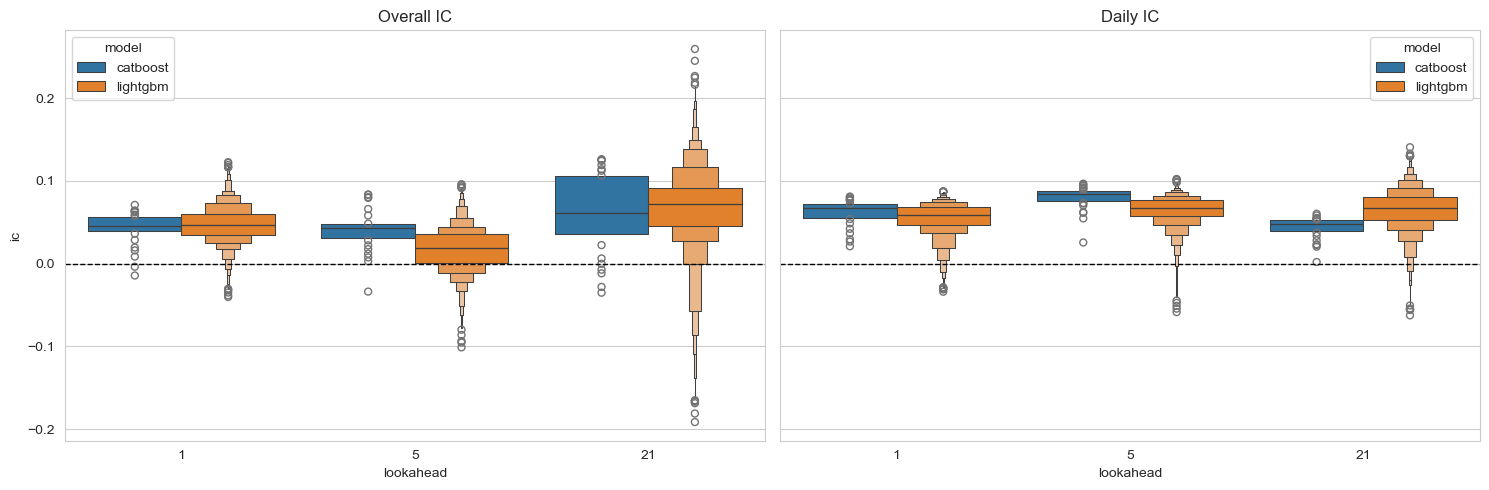

In [300]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5), sharey=True)
sns.boxenplot(x='lookahead', y='ic', hue='model',
              data=pd.concat([catboost_metrics.assign(model='catboost'), lgb_metrics.assign(model='lightgbm')]), ax=axes[0])
axes[0].axhline(0, ls='--', lw=1, c='k')
axes[0].set_title('Overall IC')
sns.boxenplot(x='lookahead', y='ic', hue='model',
              data=pd.concat([catboost_daily_ic.assign(model='catboost'), lgb_daily_ic.assign(model='lightgbm')]), ax=axes[1])
axes[1].axhline(0, ls='--', lw=1, c='k')
axes[1].set_title('Daily IC')
fig.tight_layout()

## Cross-validation Result: Best Hyperparameters

### LightGBM

The top-performing LightGBM models use the following parameters for the three different prediction horizons.

In [304]:
group_cols = scope_params + lgb_train_params + ['boost_rounds']
lgb_daily_ic.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'ic'))

lookahead  train_length  test_length  learning_rate  num_leaves  \
787           1           252           63            0.1         128   
789           1           252           63            0.1         128   
556           1           252           63            0.1           8   
3363          5           252           63            0.3           4   
3366          5           252           63            0.3           4   
3364          5           252           63            0.3           4   
7476         21          1134           63            0.3         128   
5711         21           252           63            0.1         128   
5453         21           252           63            0.1           4   

      feature_fraction  min_data_in_leaf  boost_rounds        ic  
787               0.60              1000           250  0.087264  
789               0.60              1000           350  0.087235  
556               0.60               500           400  0.086992  
3363              0.30              1000           350  0.102219  
3366              0.30              1000           500  0.101822  
3364              0.30              1000           400  0.100828  
7476              0.30               500            25  0.140597  
5711              0.30              1000           100  0.132759  
5453              0.95              1000           200  0.130738

In [305]:
lgb_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'ic'))
lgb_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'ic')).to_csv('results/best_lgb_model.csv', index=False)

In [306]:
lgb_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'daily_ic_mean'))

lookahead  train_length  test_length  learning_rate  num_leaves  \
444           1           252           63            0.1       128.0   
1027          1           252           63            0.1       128.0   
1610          1           252           63            0.1       128.0   
12            5           252           63            0.3         4.0   
595           5           252           63            0.3         4.0   
1178          5           252           63            0.3         4.0   
310          21          1134           63            0.3       128.0   
893          21          1134           63            0.3       128.0   
1476         21          1134           63            0.3       128.0   

      feature_fraction  min_data_in_leaf  daily_ic_mean  daily_ic_mean_n  \
444                0.6            1000.0       0.087264            250.0   
1027               0.6            1000.0       0.087264            250.0   
1610               0.6            1000.0       0.087264            250.0   
12                 0.3            1000.0       0.102219            350.0   
595                0.3            1000.0       0.102219            350.0   
1178               0.3            1000.0       0.102219            350.0   
310                0.3             500.0       0.140597             25.0   
893                0.3             500.0       0.140597             25.0   
1476               0.3             500.0       0.140597             25.0   

      daily_ic_median  daily_ic_median_n  boost_rounds        ic  
444          0.101107              400.0            10  0.003966  
1027         0.101107              400.0            25  0.021258  
1610         0.101107              400.0            50  0.028894  
12           0.105943              400.0            10  0.013390  
595          0.105943              400.0            25  0.026589  
1178         0.105943              400.0            50  0.030781  
310          0.160095               25.0            10  0.167818  
893          0.160095               25.0            25  0.244983  
1476         0.160095               25.0            50  0.218435

### CatBoost

In [307]:
group_cols = scope_params + catboost_train_params + ['boost_rounds']
catboost_daily_ic.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'ic'))

lookahead  train_length  test_length  max_depth  min_child_samples  \
27          1          1134           63          3                500   
26          1          1134           63          3                500   
25          1          1134           63          3                500   
47          5          1134           63          3                500   
48          5          1134           63          3                500   
49          5          1134           63          3                500   
75         21          1134           63          7                250   
76         21          1134           63          7                250   
77         21          1134           63          7                250   

    boost_rounds        ic  
27          1000  0.081037  
26           900  0.080443  
25           800  0.078861  
47           200  0.096650  
48           300  0.095275  
49           400  0.094084  
75           200  0.060232  
76           300  0.058229  
77           400  0.055174

In [308]:
catboost_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'ic'))

lookahead  train_length  test_length  max_depth  min_child_samples  \
35          1          1134           63        3.0              500.0   
29          1          1134           63        3.0              500.0   
41          1          1134           63        3.0              500.0   
7           5          1134           63        3.0              500.0   
79          5          1134           63        3.0              500.0   
73          5          1134           63        3.0              500.0   
45         21          1134           63        7.0              250.0   
33         21          1134           63        7.0              250.0   
39         21          1134           63        7.0              250.0   

    daily_ic_mean  daily_ic_mean_n  daily_ic_median  daily_ic_median_n  \
35       0.081037           1000.0         0.089561             1000.0   
29       0.081037           1000.0         0.089561             1000.0   
41       0.081037           1000.0         0.089561             1000.0   
7        0.096650            200.0         0.099047              200.0   
79       0.096650            200.0         0.099047              200.0   
73       0.096650            200.0         0.099047              200.0   
45       0.060232            200.0         0.062594             1000.0   
33       0.060232            200.0         0.062594             1000.0   
39       0.060232            200.0         0.062594             1000.0   

    boost_rounds        ic  
35           200  0.070939  
29           100  0.064083  
41           300  0.063815  
7             25  0.083634  
79          1000  0.083049  
73           900  0.080409  
45           400  0.125985  
33           200  0.125863  
39           300  0.124174

In [309]:
catboost_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'daily_ic_mean'))

lookahead  train_length  test_length  max_depth  min_child_samples  \
5           1          1134           63        3.0              500.0   
11          1          1134           63        3.0              500.0   
17          1          1134           63        3.0              500.0   
1           5          1134           63        3.0              500.0   
7           5          1134           63        3.0              500.0   
13          5          1134           63        3.0              500.0   
3          21          1134           63        7.0              250.0   
9          21          1134           63        7.0              250.0   
15         21          1134           63        7.0              250.0   

    daily_ic_mean  daily_ic_mean_n  daily_ic_median  daily_ic_median_n  \
5        0.081037           1000.0         0.089561             1000.0   
11       0.081037           1000.0         0.089561             1000.0   
17       0.081037           1000.0         0.089561             1000.0   
1        0.096650            200.0         0.099047              200.0   
7        0.096650            200.0         0.099047              200.0   
13       0.096650            200.0         0.099047              200.0   
3        0.060232            200.0         0.062594             1000.0   
9        0.060232            200.0         0.062594             1000.0   
15       0.060232            200.0         0.062594             1000.0   

    boost_rounds        ic  
5             10  0.040672  
11            25  0.043312  
17            50  0.055454  
1             10 -0.033719  
7             25  0.083634  
13            50  0.028072  
3             10  0.006313  
9             25  0.041408  
15            50  0.091578

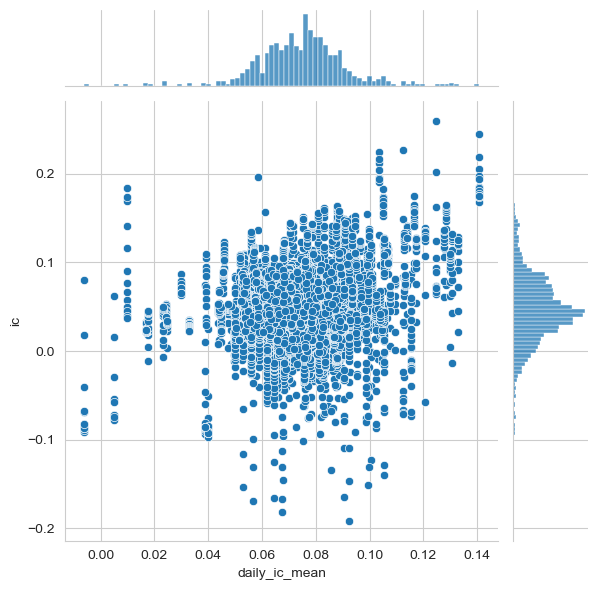

In [310]:
sns.jointplot(x=lgb_metrics.daily_ic_mean,y=lgb_metrics.ic);

### Visualization

#### LightGBM

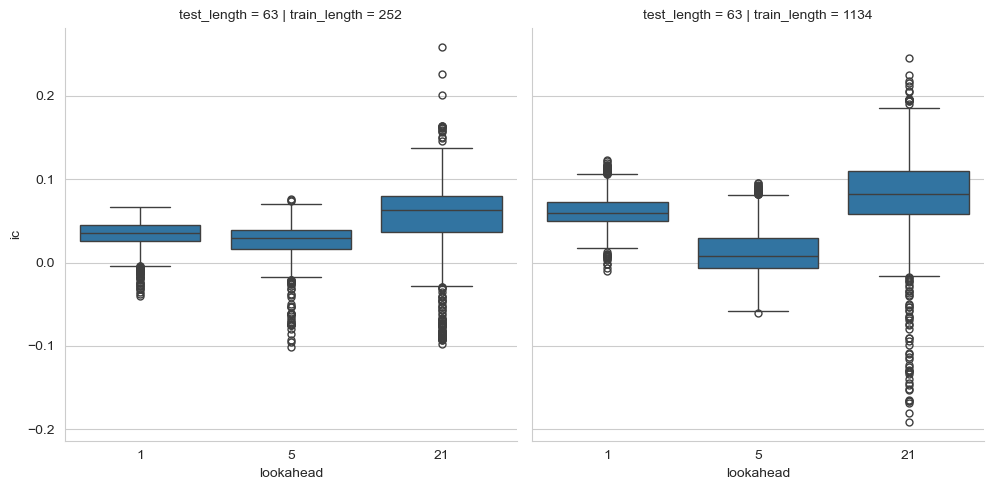

In [311]:
g = sns.catplot(x='lookahead', y='ic',
                col='train_length', row='test_length',
                data=lgb_metrics,
                kind='box')

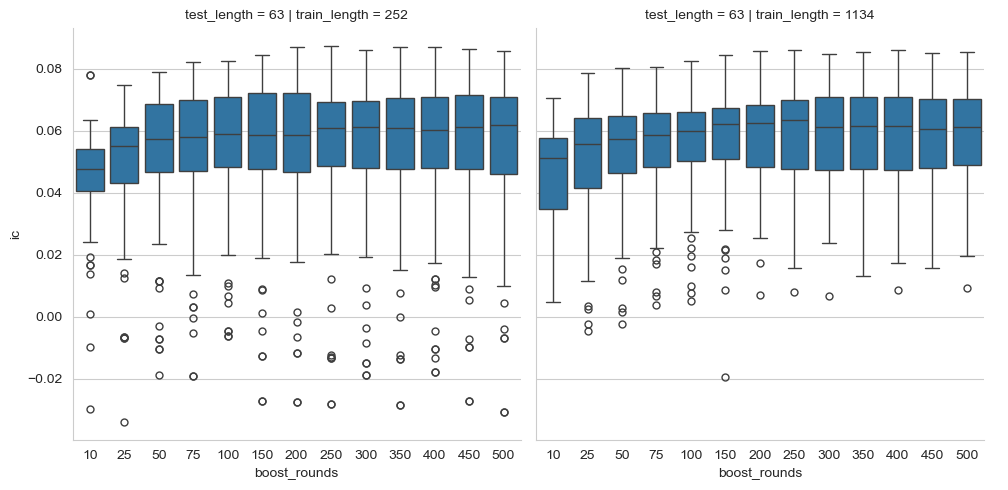

In [312]:
t=1
g=sns.catplot(x='boost_rounds',
            y='ic',
            col='train_length',
            row='test_length',
            data=lgb_daily_ic[lgb_daily_ic.lookahead == t],
            kind='box')

#### CatBoost

Some figures are empty because we did not run those parameter combinations.

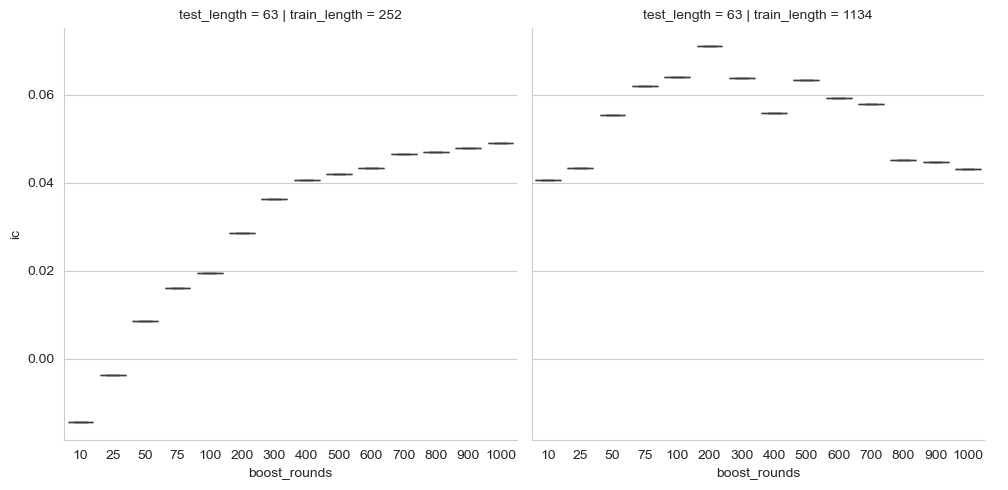

In [313]:
t = 1
g=sns.catplot(x='boost_rounds',
            y='ic',
            col='train_length',
            row='test_length',
            data=catboost_metrics[catboost_metrics.lookahead == t],
            kind='box')

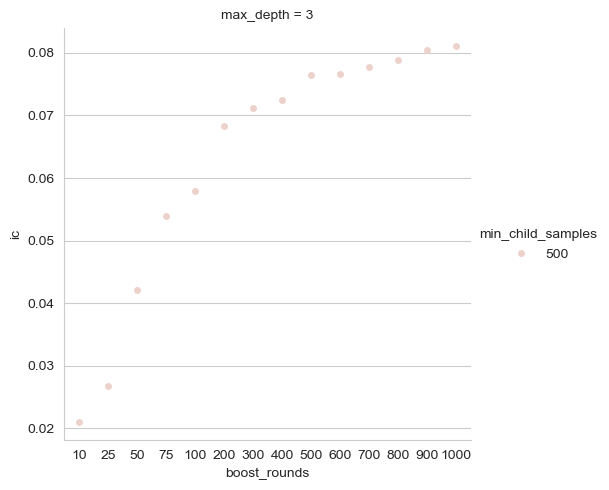

In [314]:
t = 1
train_length = 1134
test_length = 63
g = sns.catplot(
    x='boost_rounds',
    y='ic',
    col='max_depth',
    hue='min_child_samples',
    data=catboost_daily_ic[(catboost_daily_ic.lookahead == t) &
                      (catboost_daily_ic.train_length == train_length) &
                      (catboost_daily_ic.test_length == test_length)],
    kind='swarm')

## AlphaLens Analysis - Validation Performance

### LightGBM

#### Select Parameters

In [315]:
lgb_daily_ic = pd.read_hdf('data/model_tuning.h5', 'lgb/daily_ic')
lgb_daily_ic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7579 entries, 0 to 7578
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   lookahead         7579 non-null   int64  
 1   train_length      7579 non-null   int64  
 2   test_length       7579 non-null   int64  
 3   learning_rate     7579 non-null   float64
 4   num_leaves        7579 non-null   int64  
 5   feature_fraction  7579 non-null   float64
 6   min_data_in_leaf  7579 non-null   int64  
 7   boost_rounds      7579 non-null   int64  
 8   ic                7579 non-null   float64
dtypes: float64(3), int64(6)
memory usage: 592.1 KB


In [316]:
def get_lgb_params(data, t=5, best=0):
    param_cols = scope_params[1:] + lgb_train_params + ['boost_rounds']
    df = data[data.lookahead==t].sort_values('ic', ascending=False).iloc[best]
    return df.loc[param_cols]

In [317]:
def get_lgb_key(t, p):
    key = f'{t}/{int(p.train_length)}/{int(p.test_length)}/{p.learning_rate}/'
    return key + f'{int(p.num_leaves)}/{p.feature_fraction}/{int(p.min_data_in_leaf)}'

In [318]:
best_params = get_lgb_params(lgb_daily_ic, t=1, best=0)
best_params

train_length         252.0
test_length           63.0
learning_rate          0.1
num_leaves           128.0
feature_fraction       0.6
min_data_in_leaf    1000.0
boost_rounds         250.0
Name: 787, dtype: float64

In [319]:
best_params.to_hdf('data.h5', 'best_params')

#### Plot rolling IC

In [320]:
def select_ic(params, ic_data, lookahead):
    return ic_data.loc[(ic_data.lookahead == lookahead) &
                       (ic_data.train_length == params.train_length) &
                       (ic_data.test_length == params.test_length) &
                       (ic_data.learning_rate == params.learning_rate) &
                       (ic_data.num_leaves == params.num_leaves) &
                       (ic_data.feature_fraction == params.feature_fraction) &
                       (ic_data.boost_rounds == params.boost_rounds), ['date', 'ic']].set_index('date')

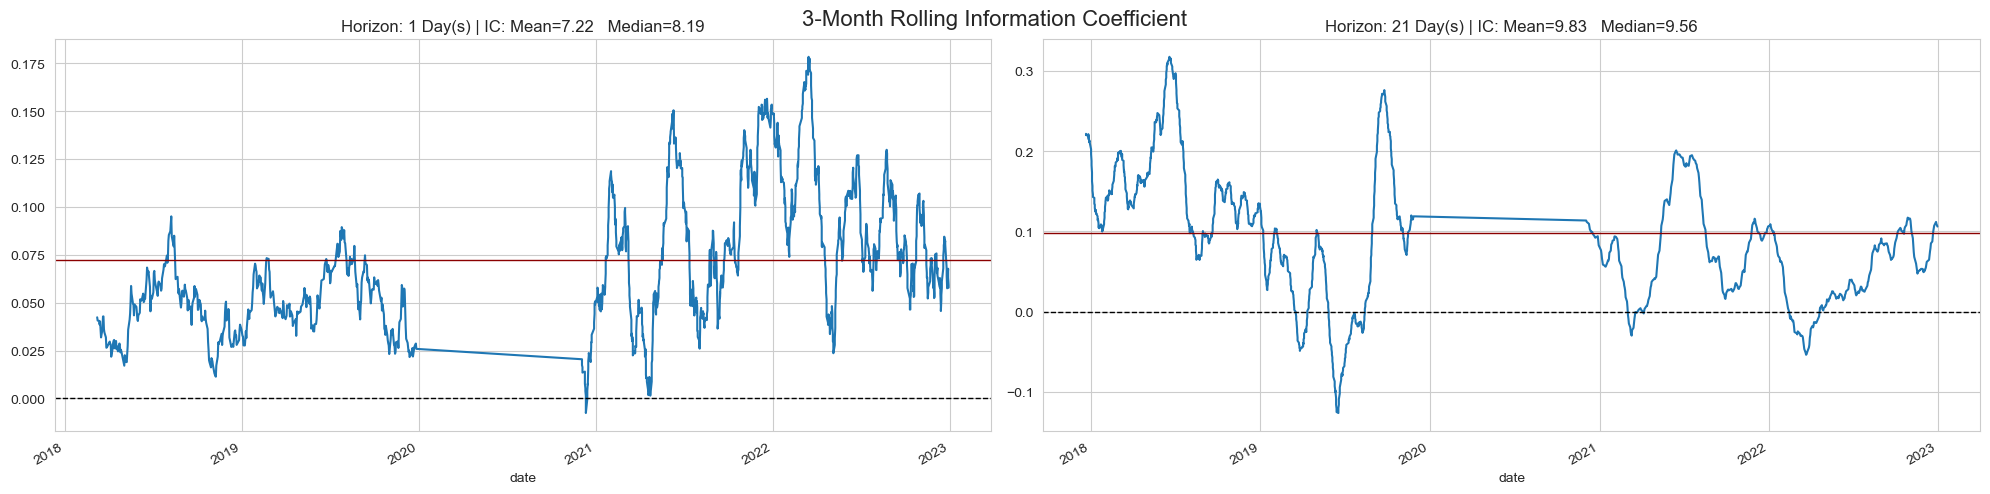

In [321]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
axes = axes.flatten()
for i, t in enumerate([1, 21]):
    params = get_lgb_params(lgb_daily_ic, t=t)
    data = select_ic(params, lgb_ic, lookahead=t).sort_index()
    rolling = data.rolling(63).ic.mean().dropna()
    avg = data.ic.mean()
    med = data.ic.median()
    rolling.plot(ax=axes[i], title=f'Horizon: {t} Day(s) | IC: Mean={avg*100:.2f}   Median={med*100:.2f}')
    axes[i].axhline(avg, c='darkred', lw=1)
    axes[i].axhline(0, ls='--', c='k', lw=1)

fig.suptitle('3-Month Rolling Information Coefficient', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.92);

#### Get Predictions for Validation Period

We retrieve the predictions for the 10 validation runs:

In [322]:
lookahead = 1
topn = 10
for best in range(topn):
    best_params = get_lgb_params(lgb_daily_ic, t=lookahead, best=best)
    key = get_lgb_key(lookahead, best_params)
    rounds = str(int(best_params.boost_rounds))
    if best == 0:
        best_predictions = pd.read_hdf(results_path / 'tuning_lgb.h5', 'predictions/' + key)
        best_predictions = best_predictions[rounds].to_frame(best)
    else:
        best_predictions[best] = pd.read_hdf(results_path / 'tuning_lgb.h5',
                                             'predictions/' + key)[rounds]
best_predictions = best_predictions.sort_index()

In [323]:
best_predictions.to_hdf('data/predictions.h5', f'lgb/train/{lookahead:02}')
best_predictions.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 21671 entries, ('ALUA.BA', Timestamp('2020-12-03 00:00:00')) to ('YPFD.BA', Timestamp('2022-12-30 00:00:00'))
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       21671 non-null  float64
 1   1       21671 non-null  float64
 2   2       21671 non-null  float64
 3   3       21671 non-null  float64
 4   4       21671 non-null  float64
 5   5       21671 non-null  float64
 6   6       21671 non-null  float64
 7   7       21671 non-null  float64
 8   8       21671 non-null  float64
 9   9       21671 non-null  float64
dtypes: float64(10)
memory usage: 1.7+ MB


#### Get Trade Prices

Using next available prices.

In [324]:
def get_trade_prices(tickers):
    idx = pd.IndexSlice
    DATA_STORE = './data/assets.h5'
    prices = (pd.read_hdf(DATA_STORE, 'merval/prices').swaplevel().sort_index())
    prices.index.names = ['symbol', 'date']
    return (prices.loc[idx[tickers, '2020': '2024'], 'adj_open']
            .unstack('symbol')
            .sort_index()
            .shift(-1)
            .tz_localize('UTC'))

In [325]:
test_tickers = best_predictions.index.get_level_values('symbol').unique()

In [326]:
trade_prices = get_trade_prices(test_tickers)
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 972 entries, 2020-01-02 00:00:00+00:00 to 2023-12-29 00:00:00+00:00
Data columns (total 43 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ALUA.BA   971 non-null    float64
 1   BBAR.BA   971 non-null    float64
 2   BMA.BA    971 non-null    float64
 3   BOLT.BA   971 non-null    float64
 4   BPAT.BA   971 non-null    float64
 5   CADO.BA   971 non-null    float64
 6   CAPX.BA   971 non-null    float64
 7   CARC.BA   970 non-null    float64
 8   CECO2.BA  971 non-null    float64
 9   CGPA2.BA  971 non-null    float64
 10  COME.BA   971 non-null    float64
 11  CRES.BA   971 non-null    float64
 12  CTIO.BA   971 non-null    float64
 13  DGCU2.BA  971 non-null    float64
 14  DOME.BA   971 non-null    float64
 15  DYCA.BA   971 non-null    float64
 16  FERR.BA   971 non-null    float64
 17  FIPL.BA   971 non-null    float64
 18  GARO.BA   971 non-null    float64
 19  GBAN.BA   971 non-null

In [327]:
# persist result in case we want to rerun:
trade_prices.to_hdf('data/model_tuning.h5', 'trade_prices/model_selection')
trade_prices = pd.read_hdf('data/model_tuning.h5', 'trade_prices/model_selection')

We average the top five models and provide the corresponding prices to Alphalens, in order to compute the mean period-wise return earned on an equal-weighted portfolio invested in the daily factor quintiles for various holding periods:

In [328]:
factor = best_predictions.iloc[:, :5].mean(1).dropna().tz_localize('UTC', level='date').swaplevel()

#### Create AlphaLens Inputs

In [329]:
factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   periods=(1, 5, 10, 21))

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


#### Compute Alphalens metrics

In [330]:
mean_quant_ret_bydate, std_quant_daily = perf.mean_return_by_quantile(
    factor_data,
    by_date=True,
    by_group=False,
    demeaned=True,
    group_adjust=False,
)

In [331]:
factor_returns = perf.factor_returns(factor_data)

In [332]:
mean_quant_ret, std_quantile = perf.mean_return_by_quantile(factor_data,
                                                            by_group=False,
                                                            demeaned=True)



mean_quant_rateret = mean_quant_ret.apply(rate_of_return, axis=0,
                                          base_period=mean_quant_ret.columns[0])

In [333]:
mean_quant_ret_bydate, std_quant_daily = perf.mean_return_by_quantile(
    factor_data,
    by_date=True,
    by_group=False,
    demeaned=True,
    group_adjust=False,
)

mean_quant_rateret_bydate = mean_quant_ret_bydate.apply(
    rate_of_return,
    base_period=mean_quant_ret_bydate.columns[0],
)

compstd_quant_daily = std_quant_daily.apply(std_conversion,
                                            base_period=std_quant_daily.columns[0])

alpha_beta = perf.factor_alpha_beta(factor_data,
                                    demeaned=True)

mean_ret_spread_quant, std_spread_quant = perf.compute_mean_returns_spread(
    mean_quant_rateret_bydate,
    factor_data["factor_quantile"].max(),
    factor_data["factor_quantile"].min(),
    std_err=compstd_quant_daily,
)

In [334]:
mean_ret_spread_quant.mean().mul(10000).to_frame('Mean Period Wise Spread (bps)').join(alpha_beta.T).T

1D         5D        10D       21D
Mean Period Wise Spread (bps)  49.956440  25.407615  17.812459  9.816277
Ann. alpha                      0.702149   0.296563   0.209978  0.102904
beta                            0.022482   0.024519   0.011398  0.019679

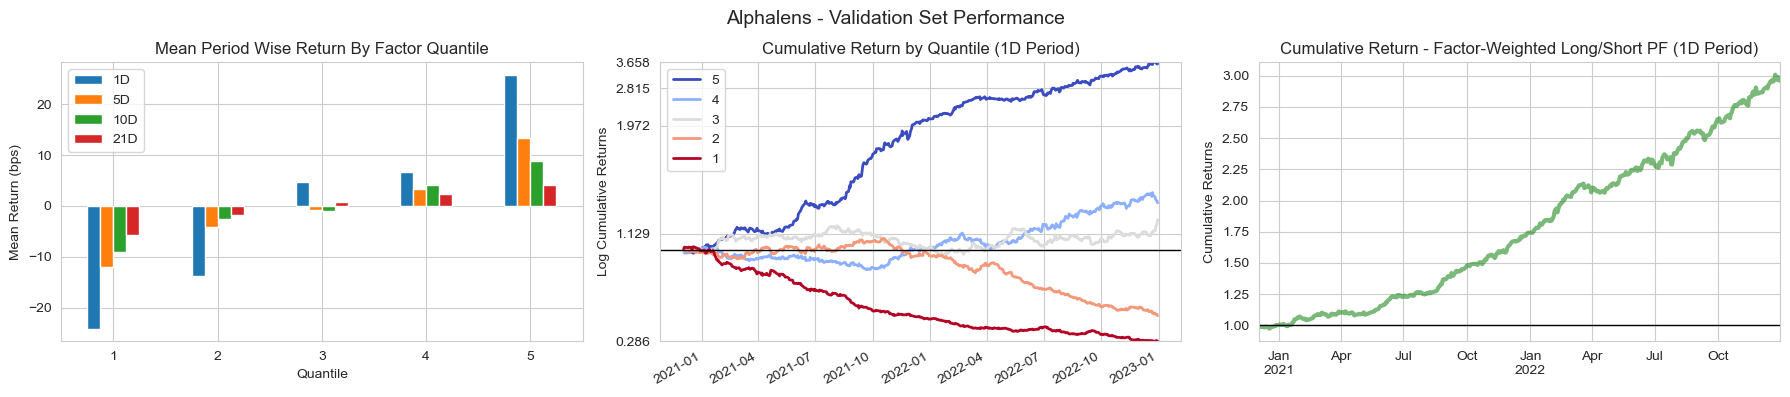

In [335]:
fig, axes = plt.subplots(ncols=3, figsize=(18, 4))


plotting.plot_quantile_returns_bar(mean_quant_rateret, ax=axes[0])
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=0)
axes[0].set_xlabel('Quantile')

plotting.plot_cumulative_returns_by_quantile(mean_quant_ret_bydate['1D'],
                                             freq=pd.tseries.offsets.BDay(),
                                             period='1D',
                                             ax=axes[1])
axes[1].set_title('Cumulative Return by Quantile (1D Period)')

title = "Cumulative Return - Factor-Weighted Long/Short PF (1D Period)"
plotting.plot_cumulative_returns(factor_returns['1D'],
                                 period='1D',
                                 freq=pd.tseries.offsets.BDay(),
                                 title=title,
                                 ax=axes[2])

fig.suptitle('Alphalens - Validation Set Performance', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85);

#### Summary Tearsheet

Quantiles Statistics


min       max      mean       std  count    count %
factor_quantile                                                          
1               -0.053964  0.018273 -0.004534  0.007432   4536  20.931198
2               -0.039775  0.021160 -0.000231  0.007359   4032  18.605510
3               -0.036607  0.024848  0.002499  0.007429   4535  20.926584
4               -0.033056  0.028143  0.005326  0.007491   4032  18.605510
5               -0.027165  0.042381  0.010460  0.007981   4536  20.931198

Returns Analysis


1D      5D     10D    21D
Ann. alpha                                      0.702   0.297   0.210  0.103
beta                                            0.022   0.025   0.011  0.020
Mean Period Wise Return Top Quantile (bps)     25.827  13.359   8.767  4.222
Mean Period Wise Return Bottom Quantile (bps) -24.130 -12.031  -9.049 -5.668
Mean Period Wise Spread (bps)                  49.956  25.408  17.812  9.816

Information Analysis


1D     5D     10D    21D
IC Mean           0.056  0.079   0.087  0.072
IC Std.           0.172  0.188   0.187  0.180
Risk-Adjusted IC  0.328  0.419   0.464  0.399
t-stat(IC)        7.366  9.405  10.413  8.959
p-value(IC)       0.000  0.000   0.000  0.000
IC Skew           0.059 -0.012  -0.037  0.085
IC Kurtosis      -0.097 -0.230  -0.101 -0.323

Turnover Analysis


1D     5D    10D    21D
Quantile 1 Mean Turnover   0.521  0.661  0.725  0.762
Quantile 2 Mean Turnover   0.743  0.776  0.808  0.814
Quantile 3 Mean Turnover   0.726  0.757  0.775  0.781
Quantile 4 Mean Turnover   0.742  0.784  0.792  0.807
Quantile 5 Mean Turnover   0.531  0.676  0.733  0.756

1D     5D    10D    21D
Mean Factor Rank Autocorrelation  0.502  0.228  0.111  0.065

<Figure size 640x480 with 0 Axes>

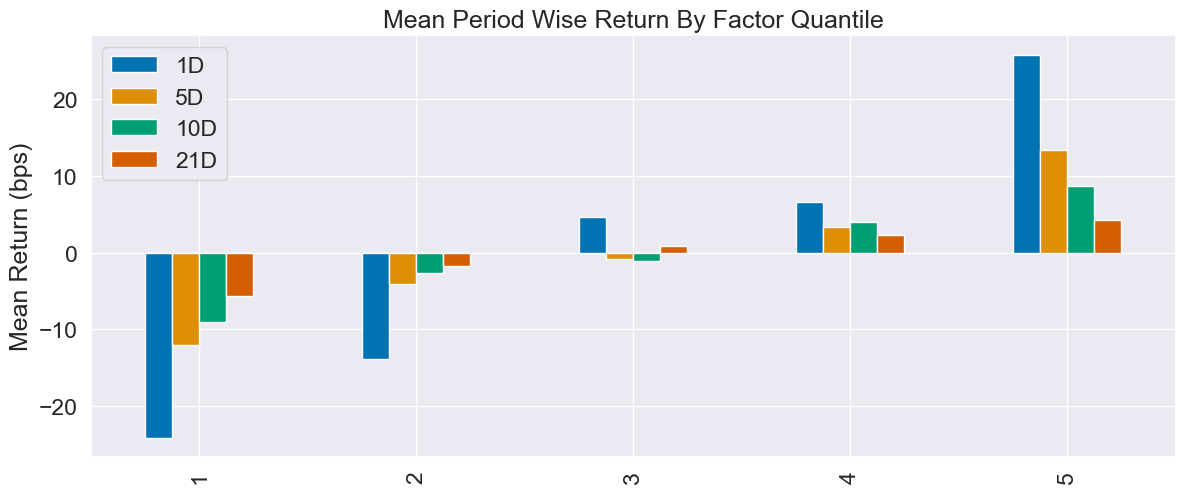

In [336]:
create_summary_tear_sheet(factor_data)

Quantiles Statistics


min       max      mean       std  count    count %
factor_quantile                                                          
1               -0.053964  0.018273 -0.004534  0.007432   4536  20.931198
2               -0.039775  0.021160 -0.000231  0.007359   4032  18.605510
3               -0.036607  0.024848  0.002499  0.007429   4535  20.926584
4               -0.033056  0.028143  0.005326  0.007491   4032  18.605510
5               -0.027165  0.042381  0.010460  0.007981   4536  20.931198

Returns Analysis


1D      5D     10D    21D
Ann. alpha                                      0.702   0.297   0.210  0.103
beta                                            0.022   0.025   0.011  0.020
Mean Period Wise Return Top Quantile (bps)     25.827  13.359   8.767  4.222
Mean Period Wise Return Bottom Quantile (bps) -24.130 -12.031  -9.049 -5.668
Mean Period Wise Spread (bps)                  49.956  25.408  17.812  9.816

<Figure size 640x480 with 0 Axes>

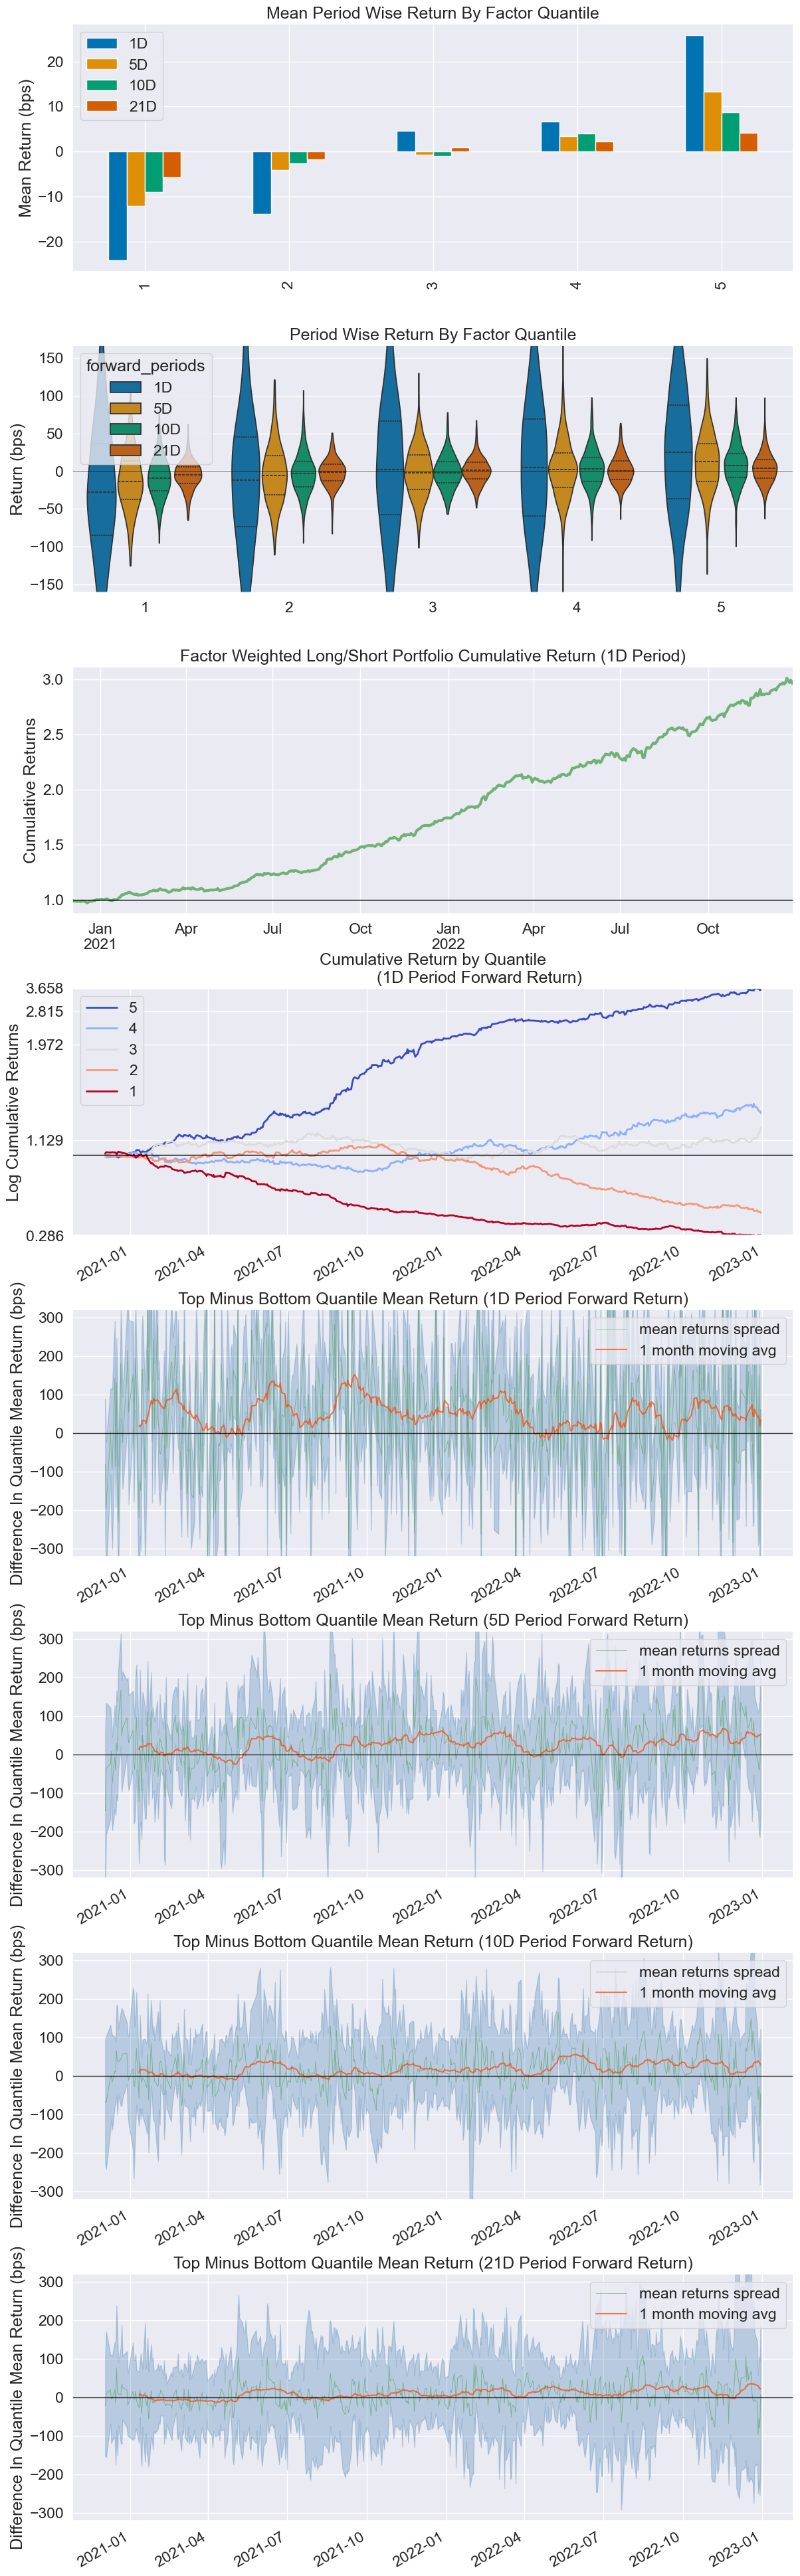

Information Analysis


1D     5D     10D    21D
IC Mean           0.056  0.079   0.087  0.072
IC Std.           0.172  0.188   0.187  0.180
Risk-Adjusted IC  0.328  0.419   0.464  0.399
t-stat(IC)        7.366  9.405  10.413  8.959
p-value(IC)       0.000  0.000   0.000  0.000
IC Skew           0.059 -0.012  -0.037  0.085
IC Kurtosis      -0.097 -0.230  -0.101 -0.323

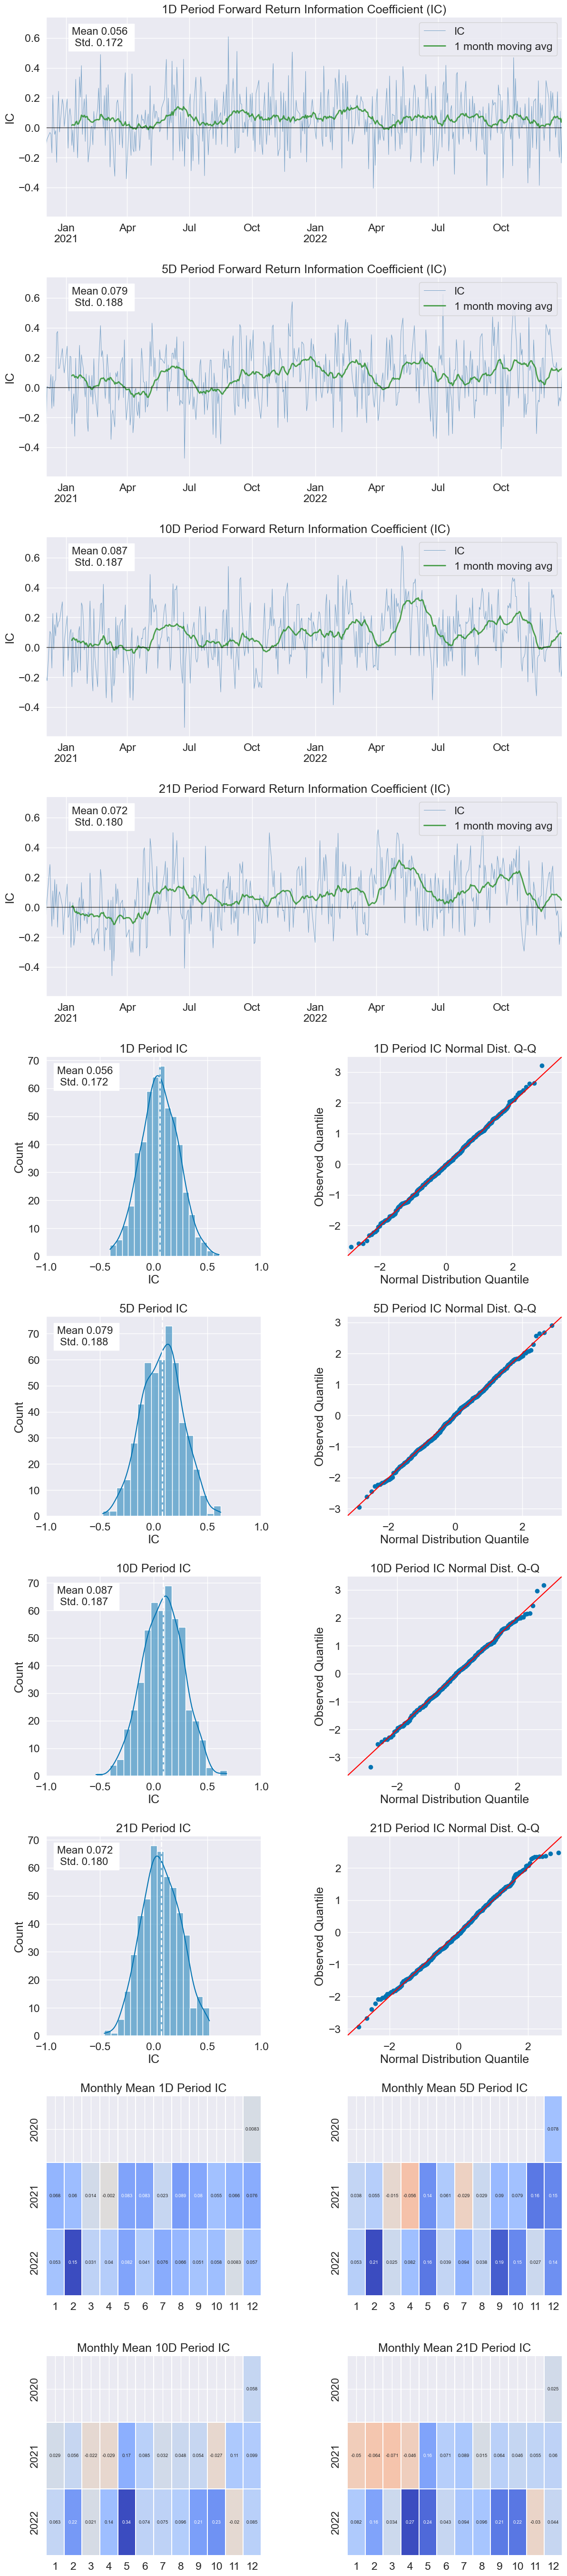

Turnover Analysis


1D     5D    10D    21D
Quantile 1 Mean Turnover   0.521  0.661  0.725  0.762
Quantile 2 Mean Turnover   0.743  0.776  0.808  0.814
Quantile 3 Mean Turnover   0.726  0.757  0.775  0.781
Quantile 4 Mean Turnover   0.742  0.784  0.792  0.807
Quantile 5 Mean Turnover   0.531  0.676  0.733  0.756

1D     5D    10D    21D
Mean Factor Rank Autocorrelation  0.502  0.228  0.111  0.065

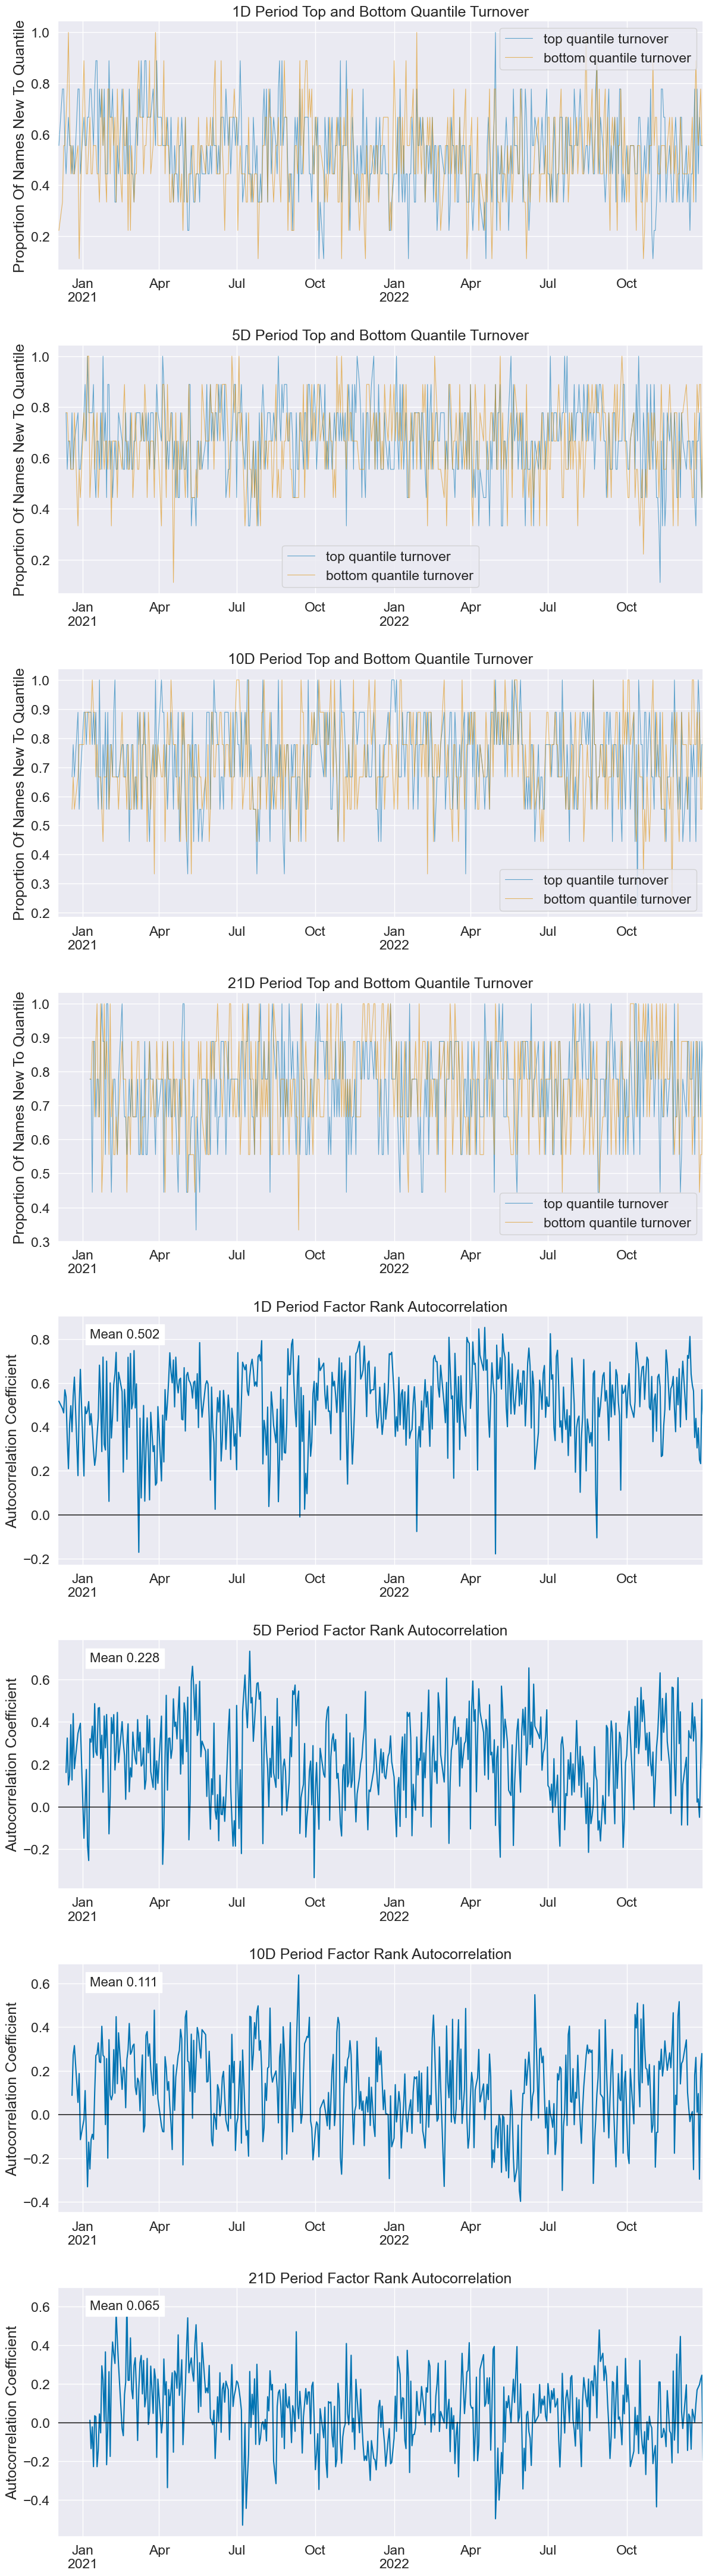

In [337]:
create_full_tear_sheet(factor_data)

### CatBoost

#### Select Parameters

In [338]:
catboost_daily_ic = pd.read_hdf('data/model_tuning.h5', 'catboost/daily_ic')
catboost_daily_ic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84 entries, 0 to 83
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   lookahead          84 non-null     int64  
 1   train_length       84 non-null     int64  
 2   test_length        84 non-null     int64  
 3   max_depth          84 non-null     int64  
 4   min_child_samples  84 non-null     int64  
 5   boost_rounds       84 non-null     int64  
 6   ic                 84 non-null     float64
dtypes: float64(1), int64(6)
memory usage: 5.2 KB


In [339]:
def get_cb_params(data, t=5, best=0):
    param_cols = scope_params[1:] + catboost_train_params + ['boost_rounds']
    df = data[data.lookahead==t].sort_values('ic', ascending=False).iloc[best]
    return df.loc[param_cols]

In [340]:
def get_cb_key(t, p):
    key = f'{t}/{int(p.train_length)}/{int(p.test_length)}/'
    return key + f'{int(p.max_depth)}/{int(p.min_child_samples)}'

In [341]:
best_params = get_cb_params(catboost_daily_ic, t=1, best=0)
best_params

train_length         1134.0
test_length            63.0
max_depth               3.0
min_child_samples     500.0
boost_rounds         1000.0
Name: 27, dtype: float64

In [342]:
def select_cb_ic(params, ic_data, lookahead):
    return ic_data.loc[(ic_data.lookahead == lookahead) &
                       (ic_data.train_length == params.train_length) &
                       (ic_data.test_length == params.test_length) &
                       (ic_data.max_depth == params.max_depth) &
                       (ic_data.min_child_samples == params.min_child_samples)].set_index('date')

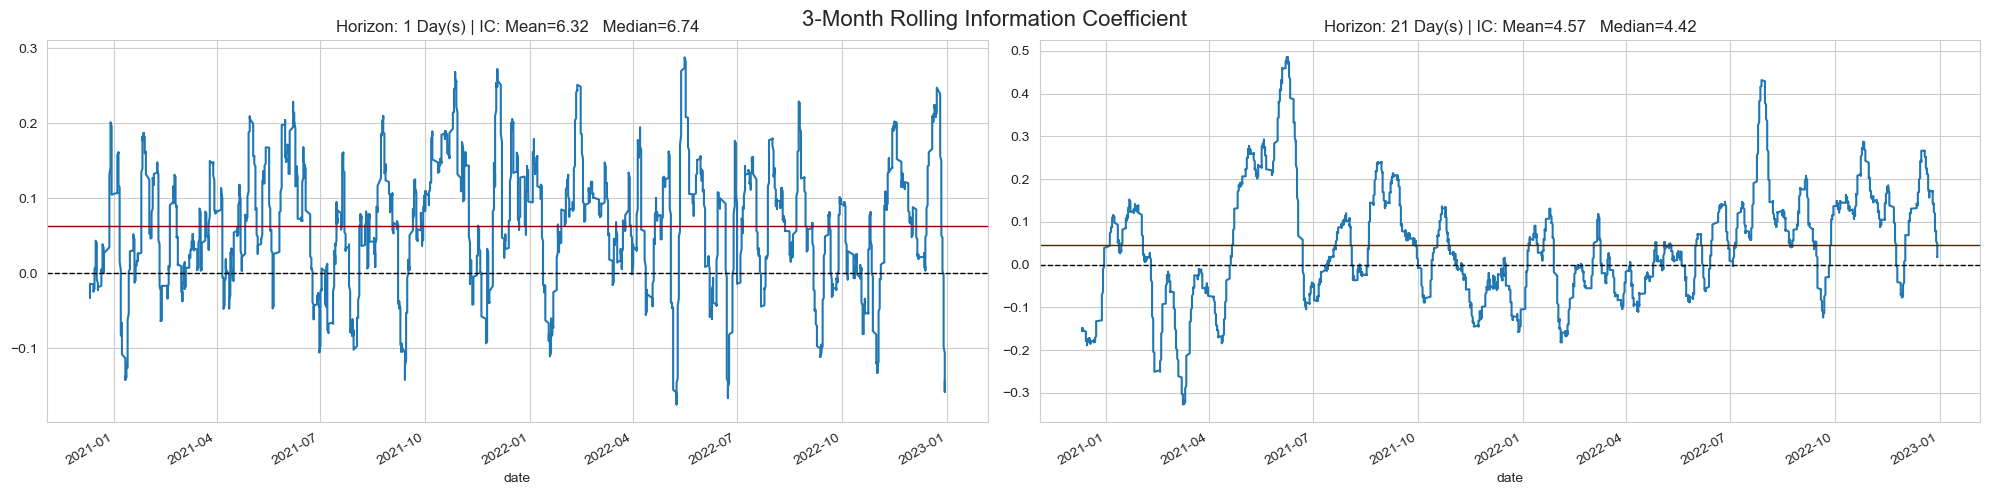

In [343]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
axes = axes.flatten()
for i, t in enumerate([1, 21]):
    params = get_cb_params(catboost_daily_ic, t=t)
    data = select_cb_ic(params, catboost_ic, lookahead=t).sort_index()
    rolling = data.rolling(63).ic.mean().dropna()
    avg = data.ic.mean()
    med = data.ic.median()
    rolling.plot(ax=axes[i], title=f'Horizon: {t} Day(s) | IC: Mean={avg*100:.2f}   Median={med*100:.2f}')
    axes[i].axhline(avg, c='darkred', lw=1)
    axes[i].axhline(0, ls='--', c='k', lw=1)

fig.suptitle('3-Month Rolling Information Coefficient', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.92);

#### Get Predictions

In [344]:
lookahead = 1
topn = 10
for best in range(topn):
    best_params = get_cb_params(catboost_daily_ic, t=lookahead, best=best)
    key = get_cb_key(lookahead, best_params)
    rounds = str(int(best_params.boost_rounds))
    if best == 0:
        best_predictions = pd.read_hdf(results_path / 'tuning_catboost.h5', 'predictions/' + key)
        best_predictions = best_predictions[rounds].to_frame(best)
    else:
        best_predictions[best] = pd.read_hdf(results_path / 'tuning_catboost.h5',
                                             'predictions/' + key)[rounds]
best_predictions = best_predictions.sort_index()

KeyError: 'No object named predictions/1/1134/63/3/500 in the file'

In [ ]:
best_predictions.to_hdf('data/predictions.h5', f'catboost/train/{lookahead:02}')
best_predictions.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 501310 entries, ('A', Timestamp('2015-01-02 00:00:00')) to ('ZION', Timestamp('2016-12-30 00:00:00'))
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       501310 non-null  float64
 1   1       501310 non-null  float64
 2   2       501310 non-null  float64
 3   3       501310 non-null  float64
 4   4       501310 non-null  float64
 5   5       501310 non-null  float64
 6   6       501310 non-null  float64
 7   7       501310 non-null  float64
 8   8       501310 non-null  float64
 9   9       501310 non-null  float64
dtypes: float64(10)
memory usage: 40.2+ MB


#### Get Trade Prices

Using next available prices.

In [ ]:
def get_trade_prices(tickers):
    idx = pd.IndexSlice
    DATA_STORE = '../data/assets.h5'
    prices = (pd.read_hdf(DATA_STORE, 'quandl/wiki/prices').swaplevel().sort_index())
    prices.index.names = ['symbol', 'date']
    return (prices.loc[idx[tickers, '2015': '2017'], 'adj_open']
            .unstack('symbol')
            .sort_index()
            .shift(-1)
            .tz_localize('UTC'))

In [ ]:
test_tickers = best_predictions.index.get_level_values('symbol').unique()

In [ ]:
trade_prices = get_trade_prices(test_tickers)
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 755 entries, 2015-01-02 00:00:00+00:00 to 2017-12-29 00:00:00+00:00
Columns: 995 entries, A to ZION
dtypes: float64(995)
memory usage: 5.7 MB


In [ ]:
# only generate once to save time
trade_prices.to_hdf('data/model_tuning.h5', 'trade_prices/model_selection')

In [ ]:
trade_prices = pd.read_hdf('data/model_tuning.h5', 'trade_prices/model_selection')

In [ ]:
factor = best_predictions.iloc[:, :5].mean(1).dropna().tz_localize('UTC', level='date').swaplevel()

#### Create AlphaLens Inputs

In [ ]:
factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   periods=(1, 5, 10, 21))

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


#### Summary Tearsheet

Quantiles Statistics


min       max      mean       std   count    count %
factor_quantile                                                           
1               -0.048616  0.008704 -0.001321  0.004333  100296  20.006822
2               -0.017568  0.011154  0.000004  0.003696  100247  19.997048
3               -0.012403  0.015290  0.000651  0.003633  100223  19.992260
4               -0.011378  0.022721  0.001284  0.003775  100247  19.997048
5               -0.010400  0.047750  0.002889  0.004981  100296  20.006822

Returns Analysis


1D     5D    10D    21D
Ann. alpha                                      0.176  0.077  0.057  0.049
beta                                            0.086  0.150  0.147  0.189
Mean Period Wise Return Top Quantile (bps)      6.103  4.049  3.508  3.207
Mean Period Wise Return Bottom Quantile (bps)  -6.037 -2.994 -2.581 -2.698
Mean Period Wise Spread (bps)                  12.140  7.020  6.066  5.885

Information Analysis


1D     5D    10D    21D
IC Mean           0.019  0.026  0.033  0.054
IC Std.           0.124  0.136  0.139  0.134
Risk-Adjusted IC  0.152  0.193  0.236  0.401
t-stat(IC)        3.423  4.324  5.299  9.010
p-value(IC)       0.001  0.000  0.000  0.000
IC Skew          -0.073  0.041  0.205  0.231
IC Kurtosis       0.297  0.495  0.058  0.074

Turnover Analysis


1D     5D    10D    21D
Quantile 1 Mean Turnover   0.524  0.630  0.689  0.756
Quantile 2 Mean Turnover   0.692  0.748  0.764  0.784
Quantile 3 Mean Turnover   0.719  0.765  0.776  0.785
Quantile 4 Mean Turnover   0.689  0.745  0.765  0.787
Quantile 5 Mean Turnover   0.525  0.616  0.667  0.739

1D     5D    10D    21D
Mean Factor Rank Autocorrelation  0.482  0.328  0.222  0.085

<Figure size 432x288 with 0 Axes>

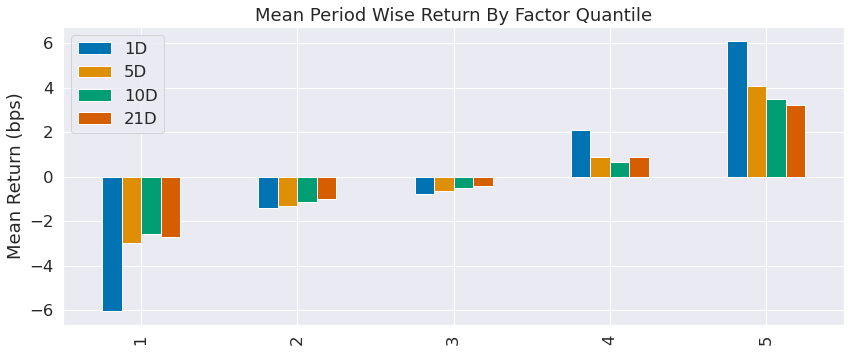

In [ ]:
create_summary_tear_sheet(factor_data)

Quantiles Statistics


min       max      mean       std   count    count %
factor_quantile                                                           
1               -0.048616  0.008704 -0.001321  0.004333  100296  20.006822
2               -0.017568  0.011154  0.000004  0.003696  100247  19.997048
3               -0.012403  0.015290  0.000651  0.003633  100223  19.992260
4               -0.011378  0.022721  0.001284  0.003775  100247  19.997048
5               -0.010400  0.047750  0.002889  0.004981  100296  20.006822

Returns Analysis


1D     5D    10D    21D
Ann. alpha                                      0.176  0.077  0.057  0.049
beta                                            0.086  0.150  0.147  0.189
Mean Period Wise Return Top Quantile (bps)      6.103  4.049  3.508  3.207
Mean Period Wise Return Bottom Quantile (bps)  -6.037 -2.994 -2.581 -2.698
Mean Period Wise Spread (bps)                  12.140  7.020  6.066  5.885

<Figure size 432x288 with 0 Axes>

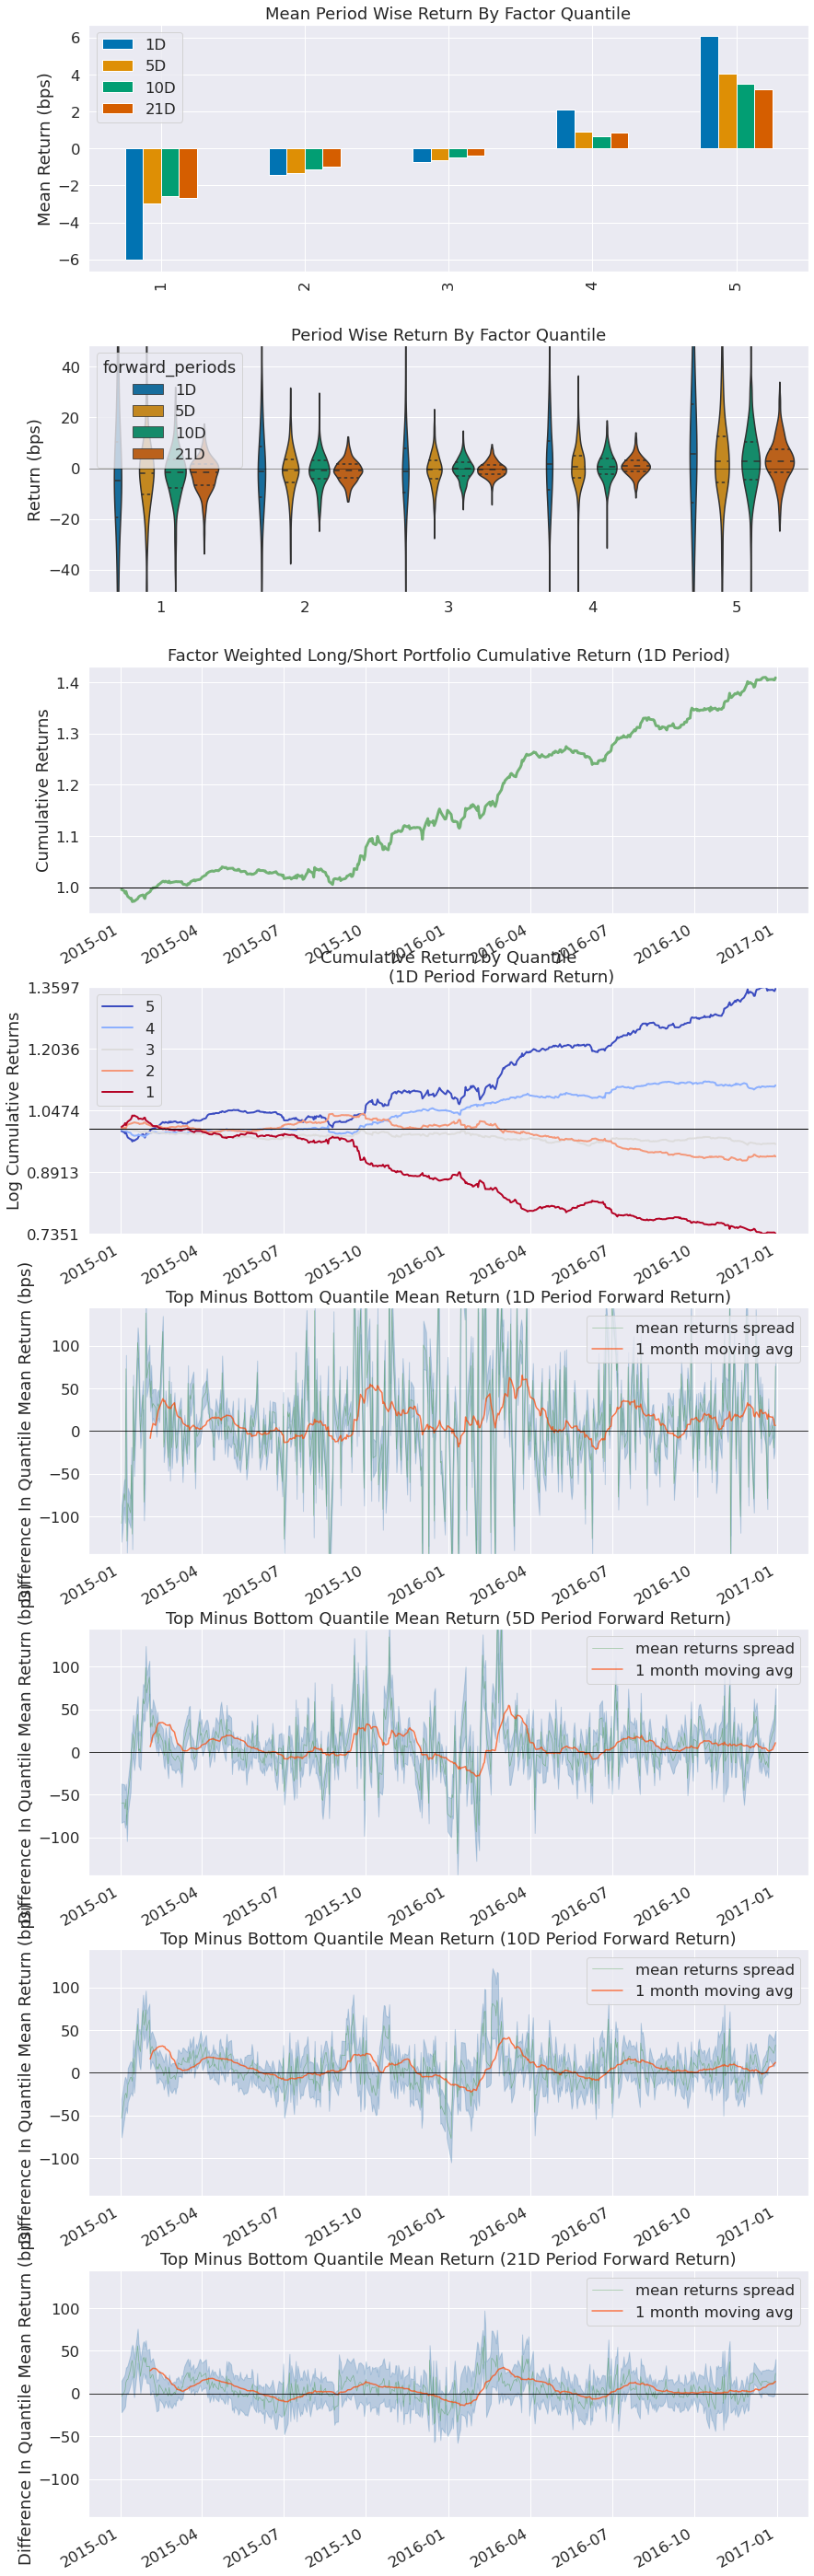

Information Analysis


1D     5D    10D    21D
IC Mean           0.019  0.026  0.033  0.054
IC Std.           0.124  0.136  0.139  0.134
Risk-Adjusted IC  0.152  0.193  0.236  0.401
t-stat(IC)        3.423  4.324  5.299  9.010
p-value(IC)       0.001  0.000  0.000  0.000
IC Skew          -0.073  0.041  0.205  0.231
IC Kurtosis       0.297  0.495  0.058  0.074

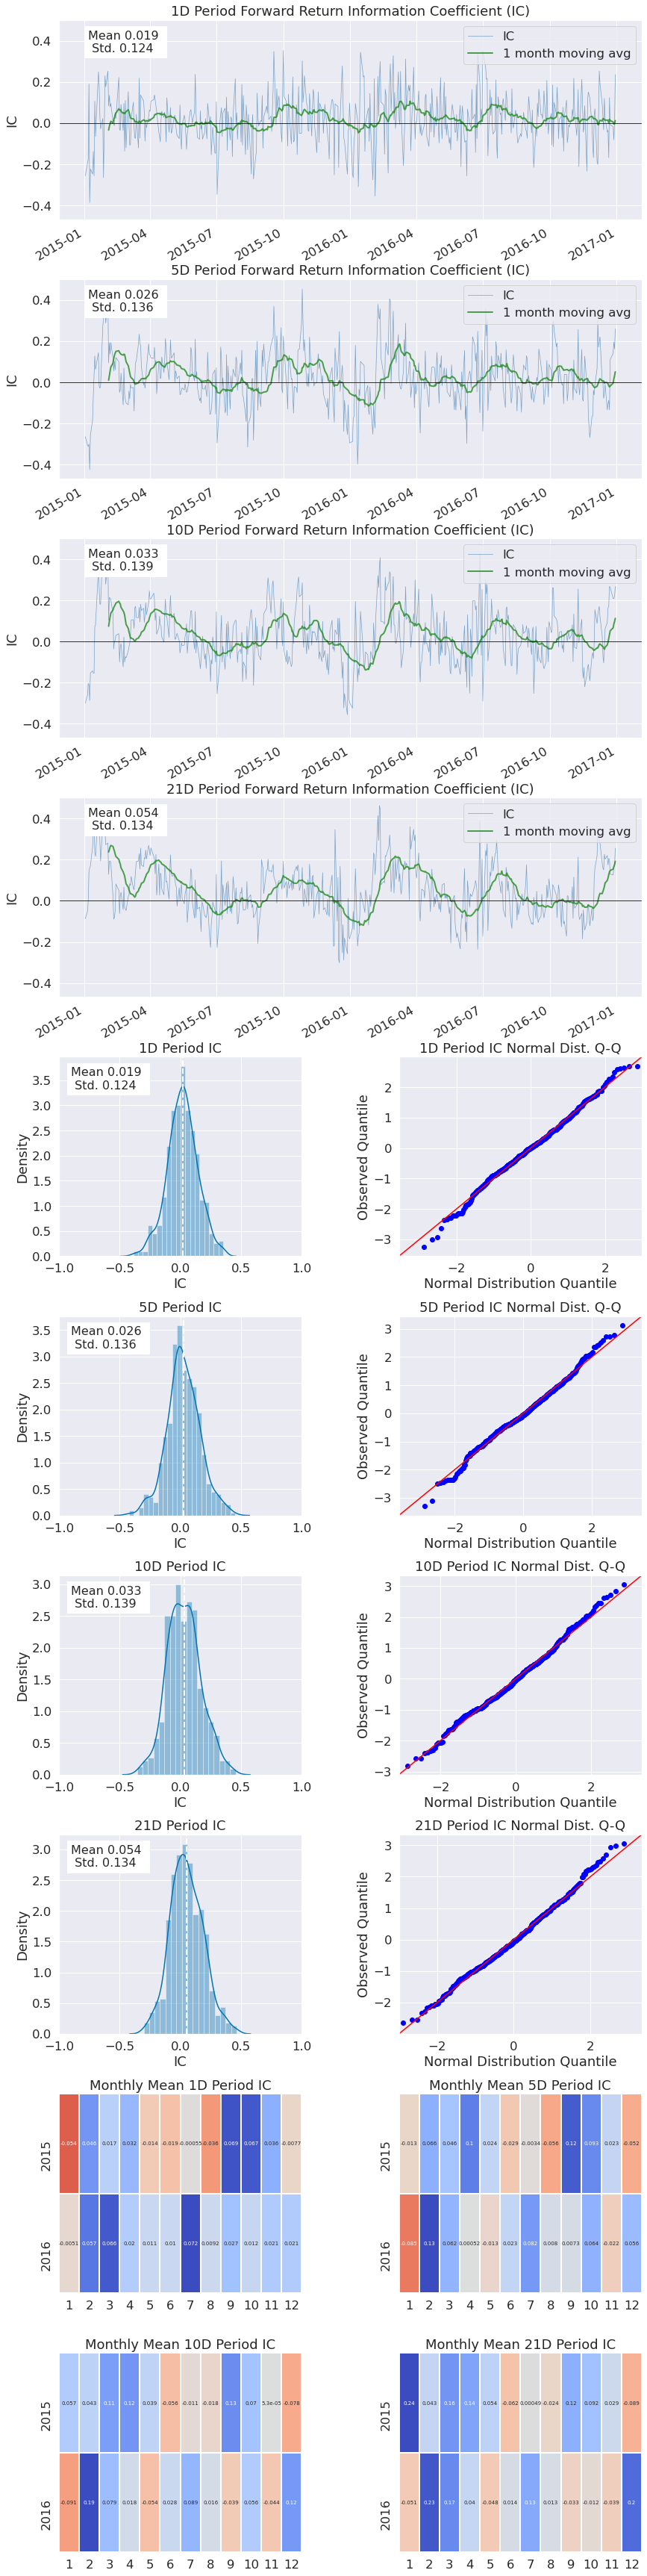

Turnover Analysis


1D     5D    10D    21D
Quantile 1 Mean Turnover   0.524  0.630  0.689  0.756
Quantile 2 Mean Turnover   0.692  0.748  0.764  0.784
Quantile 3 Mean Turnover   0.719  0.765  0.776  0.785
Quantile 4 Mean Turnover   0.689  0.745  0.765  0.787
Quantile 5 Mean Turnover   0.525  0.616  0.667  0.739

1D     5D    10D    21D
Mean Factor Rank Autocorrelation  0.482  0.328  0.222  0.085

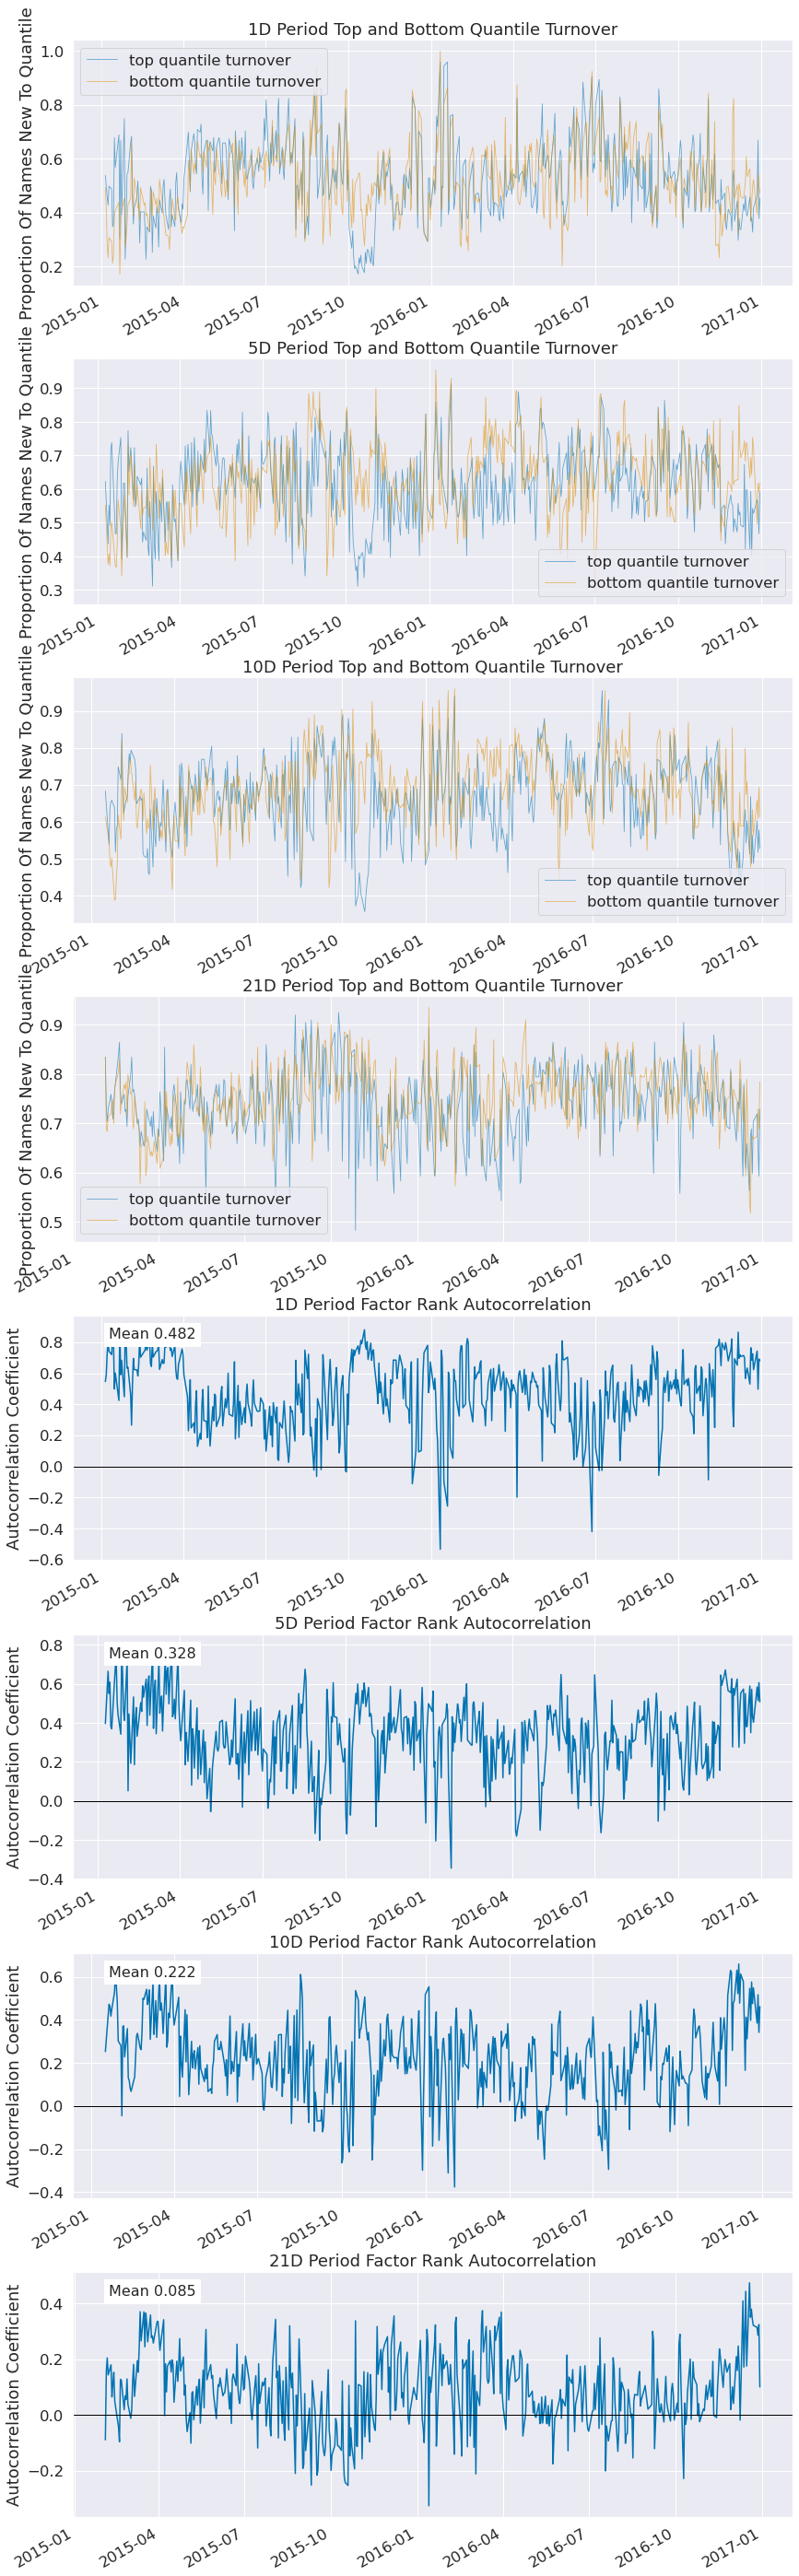

In [ ]:
create_full_tear_sheet(factor_data)